In [1]:
import pandas as pd
import datetime as dt
import pandas_datareader.data as pdr
import os
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.varmax import VARMAX
import math

In [2]:
yf.pdr_override()
y_symbols = ['AAPL', 'GOOG', 'AMZN', 'TSLA', 'MSFT']

In [3]:
startdate = dt.datetime(2015,1,1)
enddate = dt.datetime(2021,1, 1)

In [4]:
data = pdr.get_data_yahoo(y_symbols, start=startdate, end=enddate)

[*********************100%%**********************]  5 of 5 completed


In [5]:
data.head()

Adj Close                                                Close   
                 AAPL     AMZN       GOOG       MSFT       TSLA       AAPL   
Date                                                                         
2015-01-02  24.498684  15.4260  26.168653  40.534847  14.620667  27.332500  \
2015-01-05  23.808521  15.1095  25.623152  40.162094  14.006000  26.562500   
2015-01-06  23.810759  14.7645  25.029282  39.572620  14.085333  26.565001   
2015-01-07  24.144638  14.9210  24.986401  40.075401  14.063333  26.937500   
2015-01-08  25.072330  15.0230  25.065184  41.254345  14.041333  27.972500   

                                                      ...       Open            
               AMZN       GOOG       MSFT       TSLA  ...       AAPL     AMZN   
Date                                                  ...                       
2015-01-02  15.4260  26.168653  46.759998  14.620667  ...  27.847500  15.6290  \
2015-01-05  15.1095  25.623152  46.330002  14.006000  ...  27.072500  15.3505   
2015-01-06  14.7645  25.029282  45.650002  14.085333  ...  26.635000  15.1120   
2015-01-07  14.9210  24.986401  46.230000  14.063333  ...  26.799999  14.8750   
2015-01-08  15.0230  25.065184  47.590000  14.041333  ...  27.307501  15.0160   

                                                Volume                       
                 GOOG       MSFT       TSLA       AAPL      AMZN      GOOG   
Date                                                                         
2015-01-02  26.378078  46.660000  14.858000  212818400  55664000  28951268  \
2015-01-05  26.091366  46.369999  14.303333  257142000  55484000  41196796   
2015-01-06  25.679497  46.380001  14.004000  263188400  70380000  57998800   
2015-01-07  25.280592  45.980000  14.223333  160423600  52806000  41301082   
2015-01-08  24.831326  46.750000  14.187333  237458000  61768000  67071641   

                                
                MSFT      TSLA  
Date                            
2015-01-02  27913900  71466000  
2015-01-05  39673900  80527500  
2015-01-06  36447900  93928500  
2015-01-07  29114100  44526000  
2015-01-08  29645200  51637500  

[5 rows x 30 columns]

Text(0.5, 1.0, 'Stock prices')

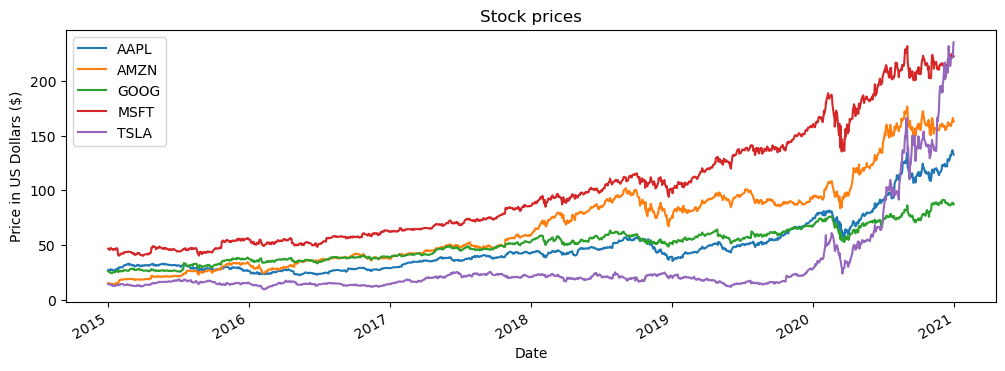

In [6]:
data.Close.plot(figsize = (12, 4))
plt.xlabel('Date')
plt.ylabel('Price in US Dollars ($)')
plt.title('Stock prices')

Most of the variation seems to happen between 2020 and 2021. Lets take a closer look

<Axes: xlabel='Date'>

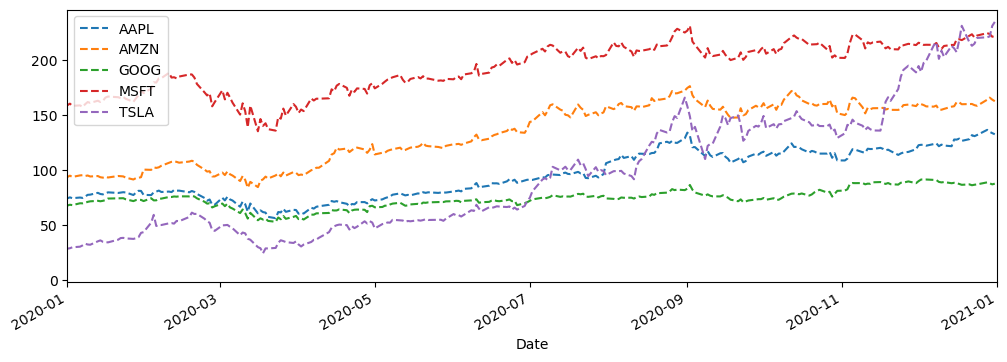

In [7]:
data.Close.plot(xlim = ['2020-01-01', '2021-01-01'], ls = '--', figsize = (12, 4))

[*********************100%%**********************]  1 of 1 completed


Text(0, 0.5, 'Prices')

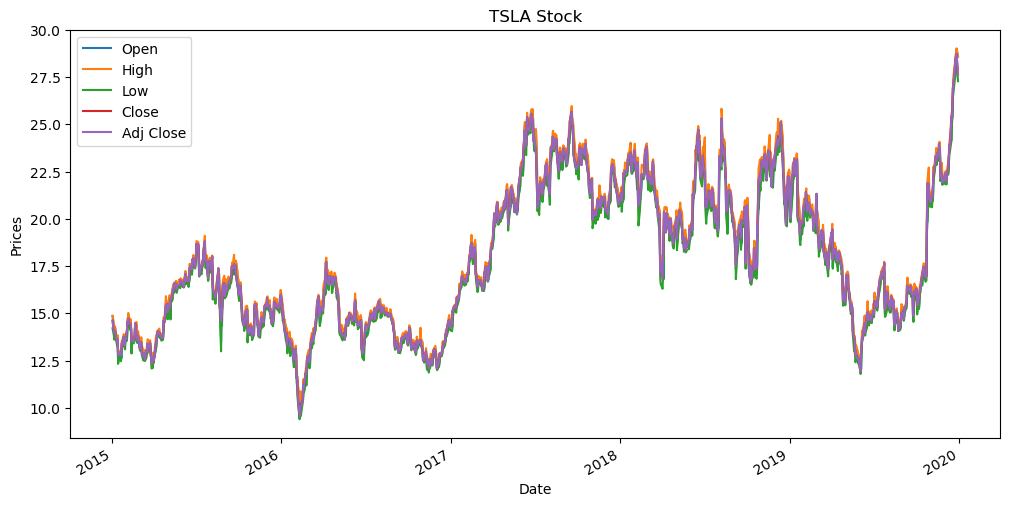

In [8]:
data = pdr.get_data_yahoo(['TSLA'], start='2015-01-01', end='2019-12-31')
data.iloc[:, :-1].plot(figsize = (12, 6))
plt.title('TSLA Stock')
plt.ylabel('Prices')

### ANALYZE GOOGLE STOCK

In [9]:
data = pdr.get_data_yahoo(['GOOG'], start='2015-01-01', end='2019-12-31')
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641


In [10]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,45.649916,46.038350,45.260461,45.663827,45.663827,3.415121e+07
std,11.523511,11.629350,11.441770,11.539933,11.539933,1.697418e+07
min,24.664783,24.730902,24.311253,24.560070,24.560070,6.950000e+06
25%,36.463501,36.737000,36.116798,36.448002,36.448002,2.426200e+07
50%,46.477001,46.694000,46.172249,46.467999,46.467999,2.976400e+07
75%,55.632999,56.210999,55.183250,55.756500,55.756500,3.899600e+07
max,68.167503,68.250000,67.633499,68.058502,68.058502,2.232980e+08


<Axes: xlabel='Date'>

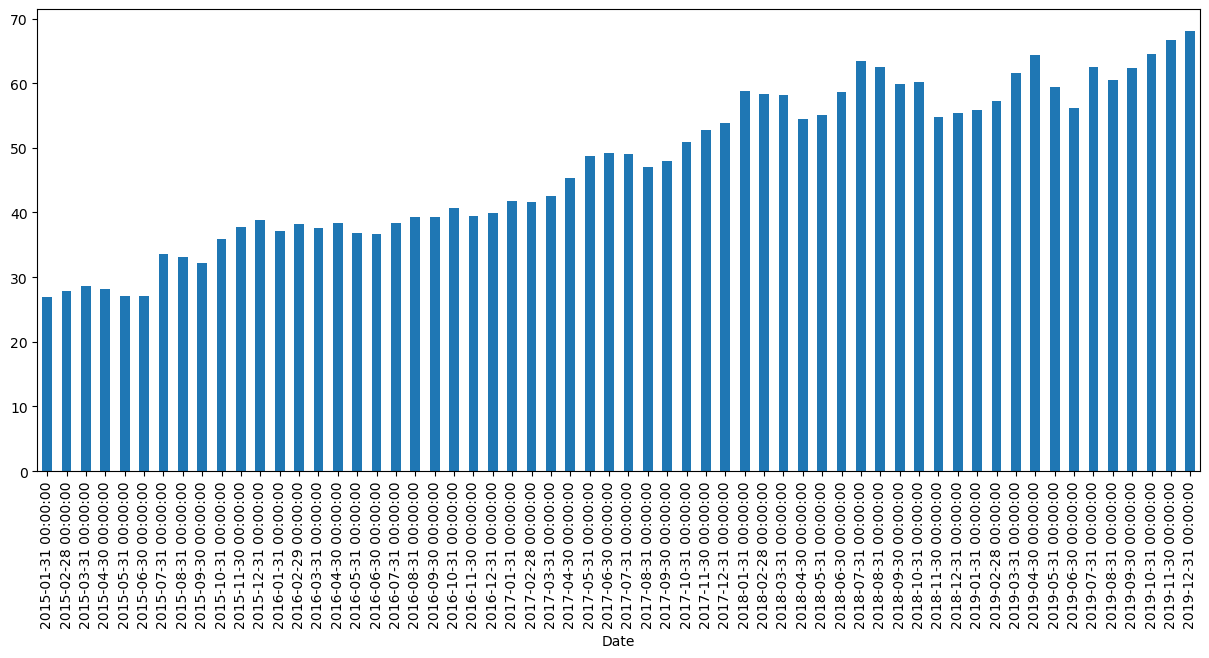

In [11]:
data.Close.resample(rule = 'M').max().plot(kind = 'bar', figsize = (15, 6))

Text(0, 0.5, 'Prices')

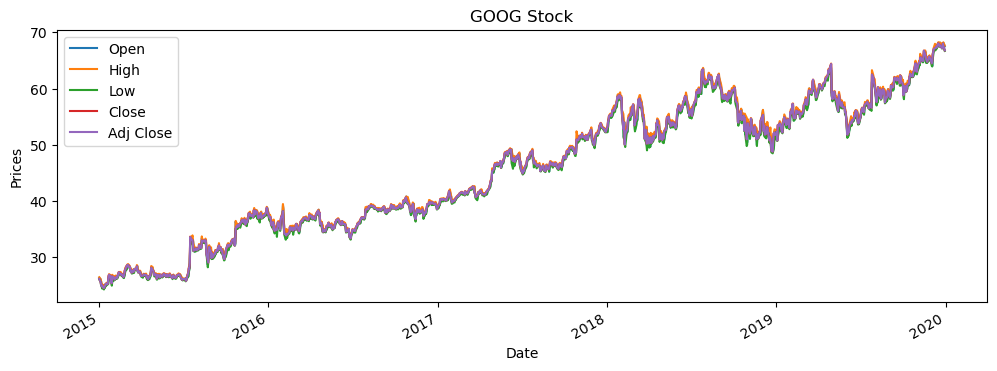

In [12]:
data.iloc[:, :-1].plot(figsize = (12, 4))
plt.title('GOOG Stock')
plt.ylabel('Prices')

<Axes: xlabel='Date'>

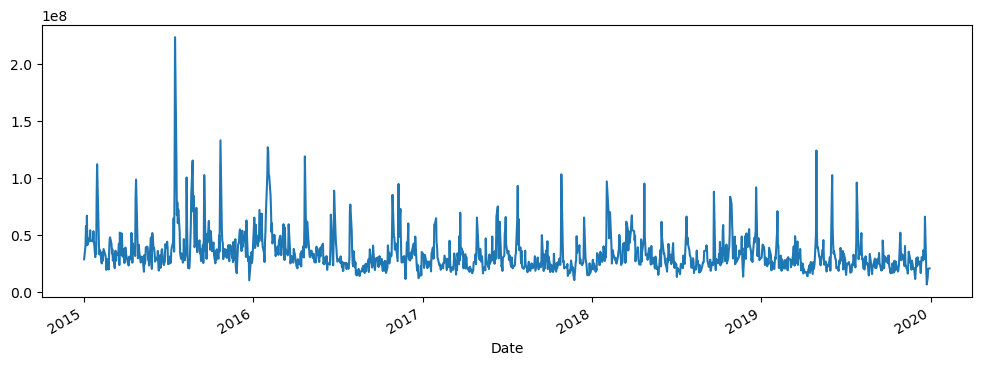

In [13]:
data.Volume.plot(figsize = (12, 4))

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

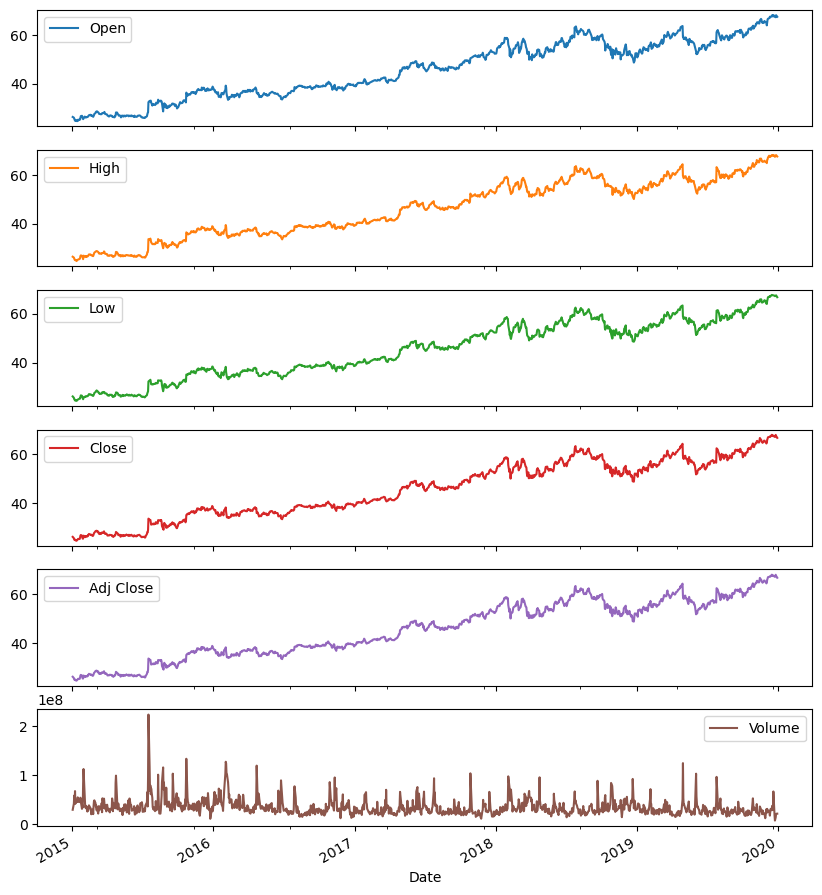

In [14]:
data.plot(subplots = True, figsize = (10, 12))

Lets look at the close value of the stock

<Axes: xlabel='Date'>

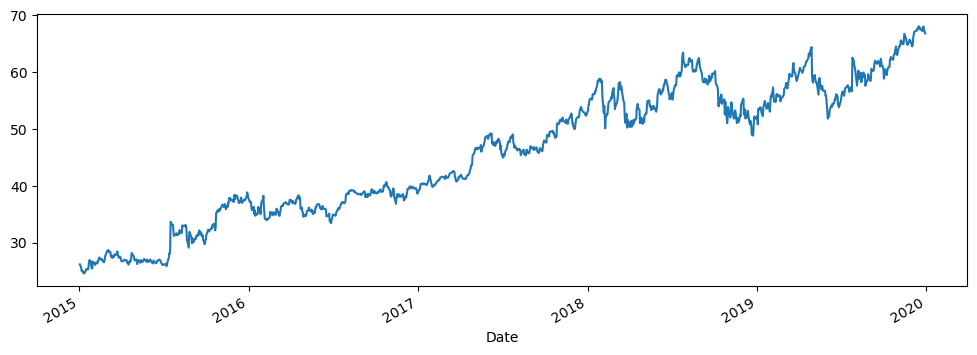

In [15]:
data.Close.plot(figsize = (12, 4))

Text(0.5, 1.0, 'Distribution of close prices over the days')

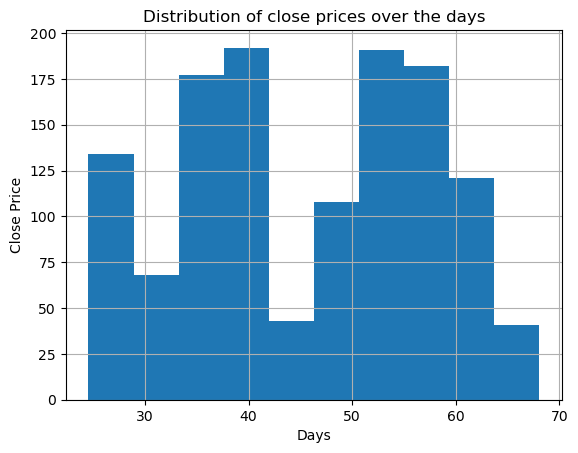

In [16]:
data.Close.hist()
plt.ylabel('Close Price')
plt.xlabel('Days')
plt.title('Distribution of close prices over the days')

In [17]:
data.Close.rolling(10).mean()

Date
2015-01-02          NaN
2015-01-05          NaN
2015-01-06          NaN
2015-01-07          NaN
2015-01-08          NaN
                ...    
2019-12-23    67.555800
2019-12-24    67.550300
2019-12-26    67.627200
2019-12-27    67.635300
2019-12-30    67.576849
Name: Close, Length: 1257, dtype: float64

### Simple Moving Average

Moving Average:
Average of the last n days

In [18]:
#Calculate moving average of first 50 days
ma20 = data.Close.rolling(20).mean()
#Calculate moving average of first 50 days
ma50 = data.Close.rolling(50).mean()
#Calculate moving average of first 100 days
ma100 = data.Close.rolling(100).mean()
#Calculate moving average of first 200 days
ma200 = data.Close.rolling(200).mean()

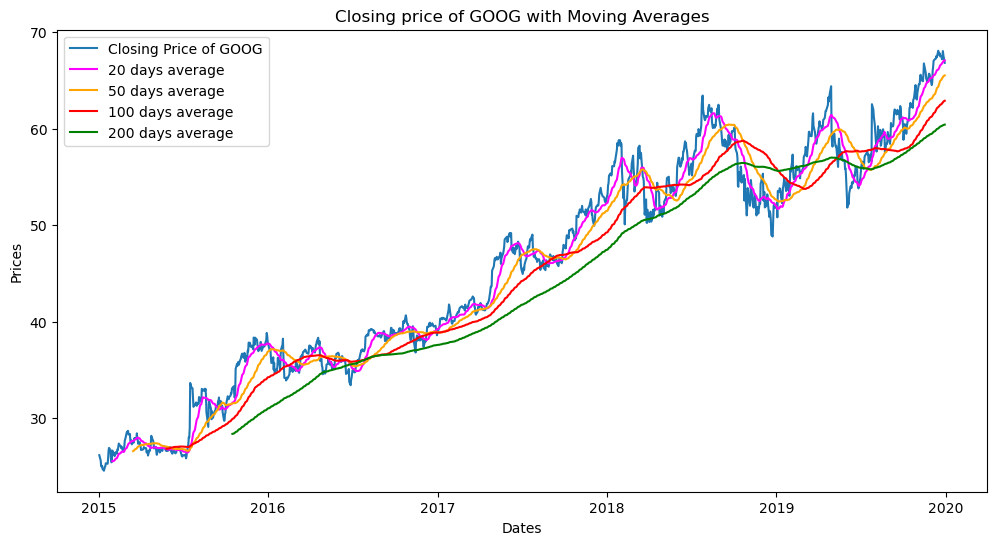

In [19]:
plt.figure(figsize = (12, 6))
plt.plot(data.Close, label = 'Closing Price of GOOG')
plt.plot(ma20, 'magenta', label = '20 days average')
plt.plot(ma50, 'orange', label = '50 days average')
plt.plot(ma100, 'r', label = '100 days average')
plt.plot(ma200, 'g', label = '200 days average')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of GOOG with Moving Averages')
plt.legend()

For 2019

In [20]:
data_2019 = pdr.get_data_yahoo(['GOOG'], start='2019-01-01', end='2019-12-31')
data_2019.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,50.828499,52.616001,50.785500,52.292500,52.292500,30652000
2019-01-03,52.049999,52.848999,50.703499,50.803001,50.803001,36822000
2019-01-04,51.629501,53.542000,51.370899,53.535500,53.535500,41878000
2019-01-07,53.575001,53.700001,52.737999,53.419498,53.419498,39638000
2019-01-08,53.805500,54.228001,53.026501,53.813999,53.813999,35298000


In [21]:
#2019
#Calculate moving average of first 50 days
ma20_2019 = data_2019.Close.rolling(20).mean()
#Calculate moving average of first 50 days
ma50_2019 = data_2019.Close.rolling(50).mean()
#Calculate moving average of first 100 days
ma100_2019 = data_2019.Close.rolling(100).mean()

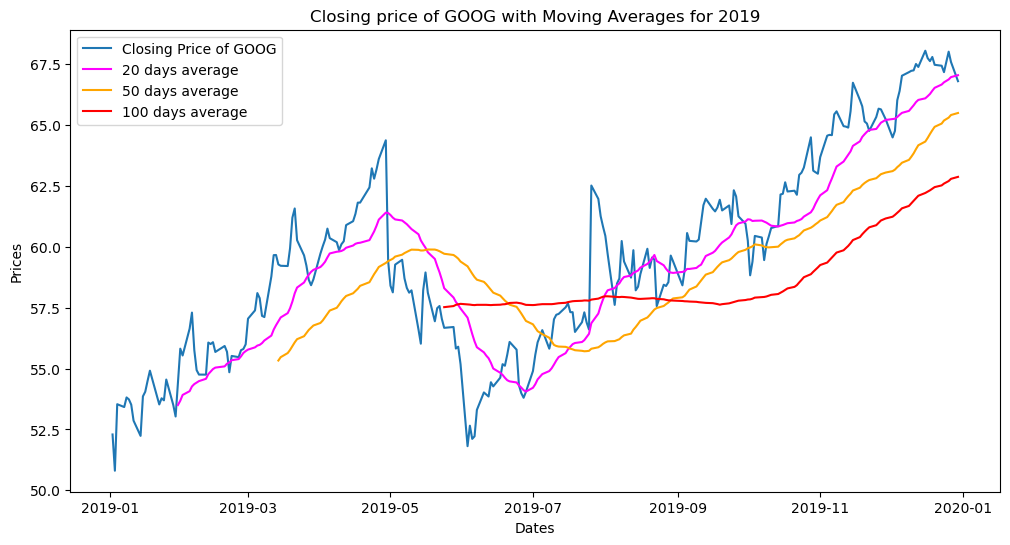

In [22]:
plt.figure(figsize = (12, 6))
plt.plot(data_2019.Close, label = 'Closing Price of GOOG')
plt.plot(ma20_2019, 'magenta', label = '20 days average')
plt.plot(ma50_2019, 'orange', label = '50 days average')
plt.plot(ma100_2019, 'r', label = '100 days average')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of GOOG with Moving Averages for 2019')
plt.legend()

### Cumulative Moving Average

In [23]:
cma_aapl = data.Close.expanding().mean()

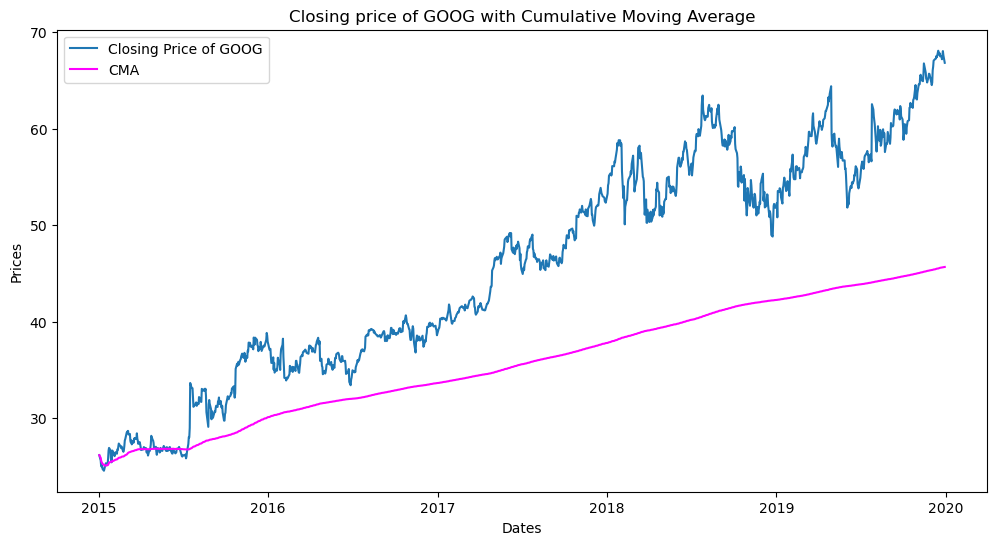

In [24]:
plt.figure(figsize = (12, 6))
plt.plot(data.Close, label = 'Closing Price of GOOG')
plt.plot(cma_aapl, 'magenta', label = 'CMA')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of GOOG with Cumulative Moving Average')
plt.legend()

In [25]:
#for 2019
cma_2019 = data_2019.Close.expanding().mean()

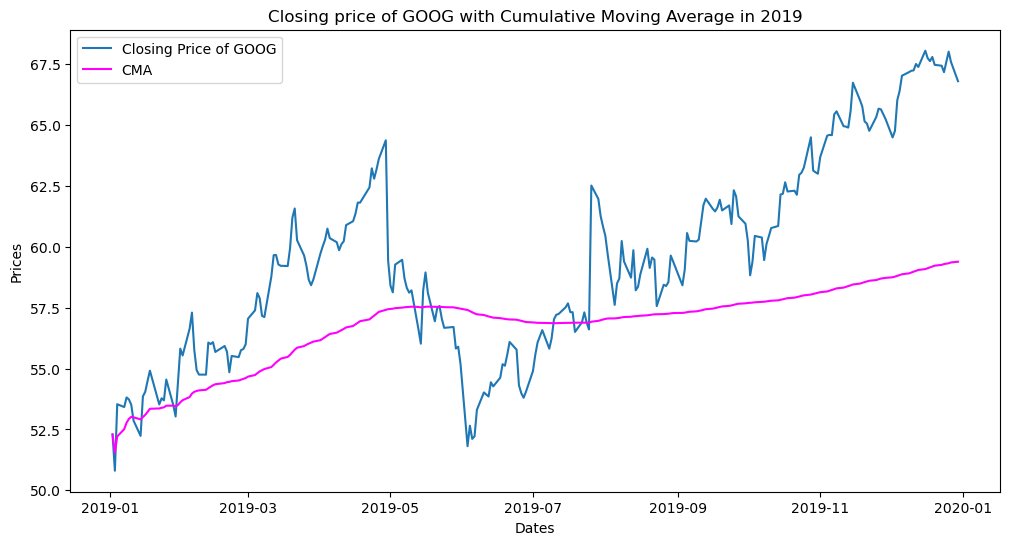

In [26]:
plt.figure(figsize = (12, 6))
plt.plot(data_2019.Close, label = 'Closing Price of GOOG')
plt.plot(cma_2019, 'magenta', label = 'CMA')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of GOOG with Cumulative Moving Average in 2019')
plt.legend()

### Exponential Weighted Moving Average (EWMA)

$ewma(t) = a * x(t) + (1-a) * ewma(t-1)$

where, $a \implies$ weight factor that gives higher priority to the price at time $t$ compared to the price at $t-1$ (This is done to prevent lags)

In [27]:
ewma_0 = data.Close.ewm(alpha = 0.1, adjust = False).mean()
ewma_1 = data.Close.ewm(alpha = 0.3, adjust = False).mean()

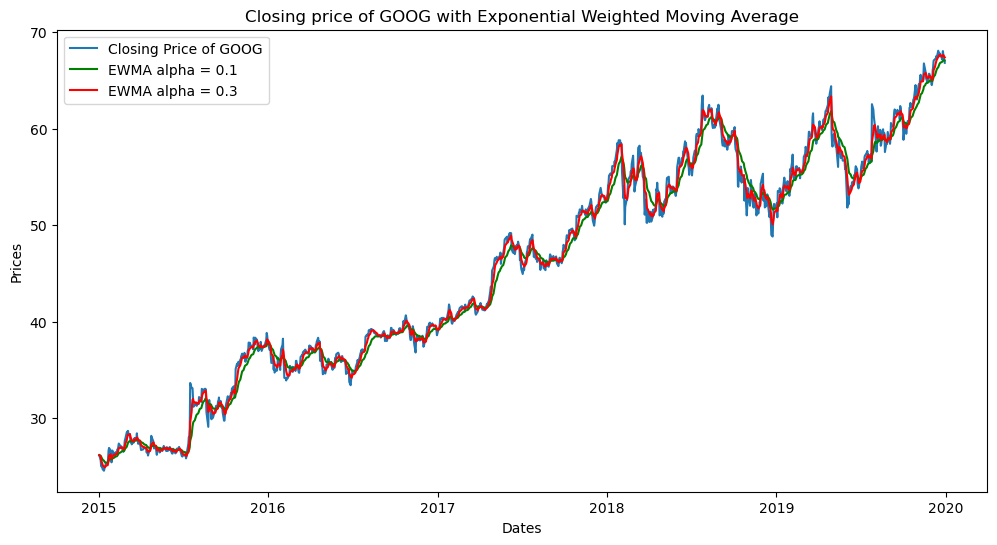

In [28]:
plt.figure(figsize = (12, 6))
plt.plot(data.Close, label = 'Closing Price of GOOG')
plt.plot(ewma_0, 'g', label = 'EWMA alpha = 0.1')
plt.plot(ewma_1, 'r', label = 'EWMA alpha = 0.3')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of GOOG with Exponential Weighted Moving Average')
plt.legend()

In [29]:
#for 2019
ewma_0_2019 = data_2019.Close.ewm(alpha = 0.1, adjust = False).mean()
ewma_1_2019 = data_2019.Close.ewm(alpha = 0.3, adjust = False).mean()

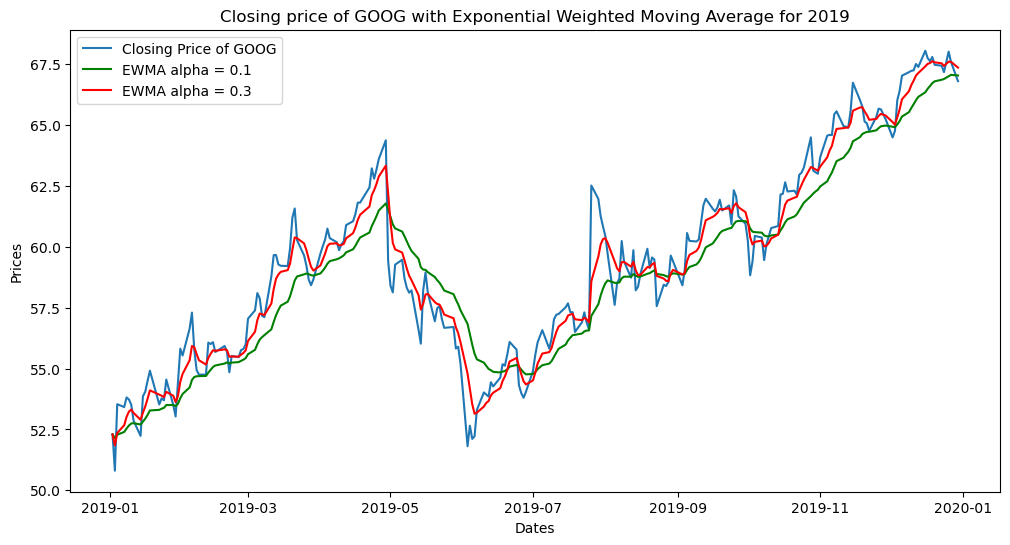

In [30]:
plt.figure(figsize = (12, 6))
plt.plot(data_2019.Close, label = 'Closing Price of GOOG')
plt.plot(ewma_0_2019, 'g', label = 'EWMA alpha = 0.1')
plt.plot(ewma_1_2019, 'r', label = 'EWMA alpha = 0.3')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of GOOG with Exponential Weighted Moving Average for 2019')
plt.legend()

### Check Trend and Seasonality

<Figure size 640x480 with 0 Axes>

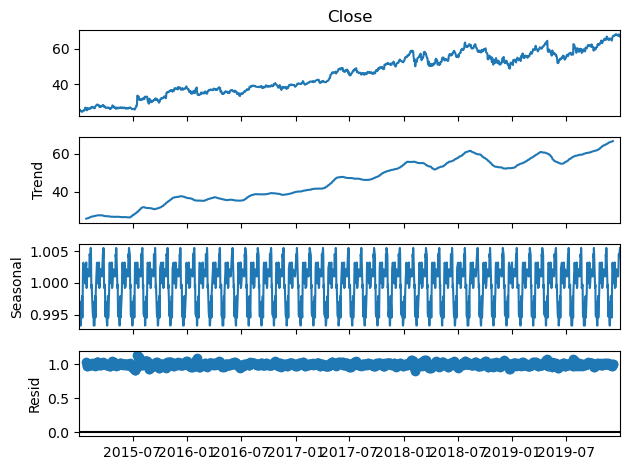

In [31]:
result = seasonal_decompose(data.Close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  

### To check if the data is stationary or not (Dickey-Fuller Test)

One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

Null Hypothesis: The series has a unit root (value of a =1) 

Alternate Hypothesis: The series has no unit root. 

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance).

In [32]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print('Reject Null Hypothesis, The data is stationary')
    else:
        print('Fail to reject Null Hypothesis, The data is not stationary')

test_stationarity(data.Close)

ADF Statistics: -0.6726351386063085
p-value: 0.8537109098961944
Fail to reject Null Hypothesis, The data is not stationary


Assuming a 95% confidence interval, the p-value is greater than 0.05. Hence we fail to reject the null hypothesis and say that the data is non-stationary. 

We need to convert the data into stationary form.

In [33]:
#Get first differencing
#data['First_differnce'] = data.Close - data.Close.shift(2)
#From above plot we see that seasonality occurs every 35 days. Hence difference by 35 days
data['First_differnce'] = data.Close.diff(2).dropna()
data.head()

,Open,High,Low,Close,Adj Close,Volume,First_differnce
Date,,,,,,,
2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268,NaN
2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796,NaN
2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800,-1.139372
2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082,-0.636751
2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641,0.035902


In [34]:
#Check Stationarity again
test_stationarity(data['First_differnce'].dropna())

ADF Statistics: -8.58303104399718
p-value: 7.637148692688236e-14
Reject Null Hypothesis, The data is stationary


Thus differencing once made the data stationary. 

The number of times we do differencing is a hyperparameter to the ARIMA model that we implement later on. 

Thus d = 1

### Auto-Corellation and Partial Auto-Corellation

In [35]:
data

,Open,High,Low,Close,Adj Close,Volume,First_differnce
Date,,,,,,,
2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268,NaN
2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796,NaN
2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800,-1.139372
2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082,-0.636751
2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641,0.035902
...,...,...,...,...,...,...,...
2019-12-23,67.793503,67.989998,67.325500,67.442001,67.442001,17662000,-0.360001
2019-12-24,67.425003,67.513000,67.139000,67.178001,67.178001,6950000,-0.301498
2019-12-26,67.308502,68.066353,67.223503,68.019997,68.019997,13350000,0.577995


Text(0, 0.5, 'Correlation with Close Price')

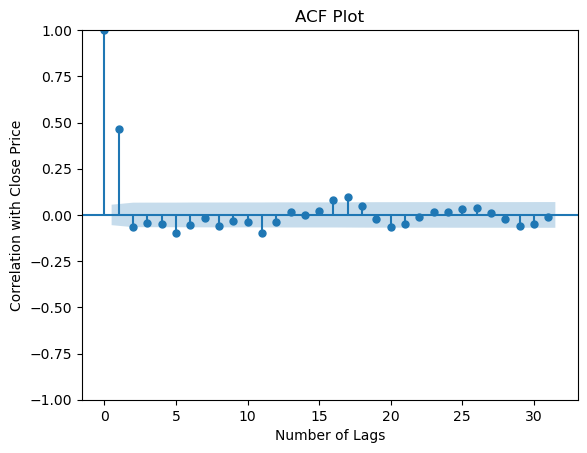

In [36]:
acf = plot_acf(data['First_differnce'].dropna())
plt.title('ACF Plot')
plt.xlabel('Number of Lags')
plt.ylabel('Correlation with Close Price')

Text(0, 0.5, 'Correlation with Close Price')

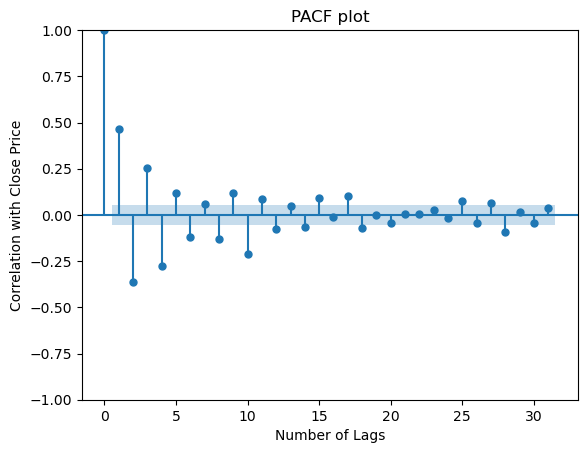

In [37]:
pacf = plot_pacf(data['First_differnce'].dropna())
plt.title('PACF plot')
plt.xlabel('Number of Lags')
plt.ylabel('Correlation with Close Price')

### Train-Test Split

In [38]:
train_data_end = dt.datetime(2018, 12, 31)
test_data_end = dt.datetime(2019, 12, 31)
train_data = data[:train_data_end]
test_data = data[train_data_end+dt.timedelta(days=1):test_data_end]

In [39]:
train_data.dropna().head()

,Open,High,Low,Close,Adj Close,Volume,First_differnce
Date,,,,,,,
2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800,-1.139372
2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082,-0.636751
2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641,0.035902
2015-01-09,25.168900,25.176876,24.671764,24.740576,24.740576,41427428,-0.245825
2015-01-12,24.679243,24.730902,24.311253,24.560070,24.560070,46535413,-0.505114


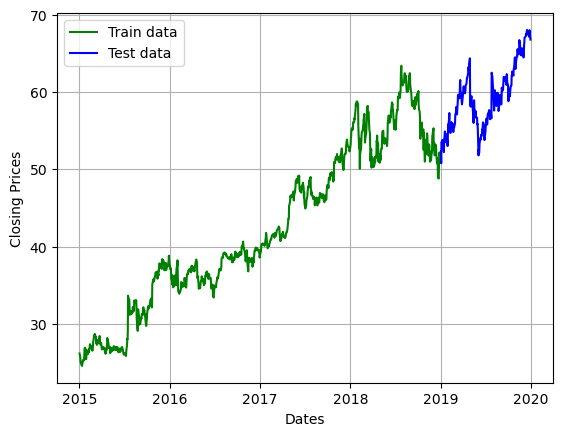

In [40]:
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data.Close, 'green', label='Train data')
plt.plot(test_data.Close, 'blue', label='Test data')
plt.legend()

### Auto-Regressive Integrated Moving Average (ARIMA)

Parameters:

p: the number of lag observations in the model; also known as the lag order.

d: the number of times that the raw observations are differenced; also known as the degree of differencing.

q: the size of the moving average window; also known as the order of the moving average.


Lets automatically discover the optimal order (hyperparameters) for the model using auto_arima library

In [41]:
model_autoARIMA = auto_arima(train_data.Close, trace = True, error_action='ignore', suppress_warnings=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1972.625, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1973.656, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1973.537, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1972.196, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.150 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1006
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -985.098
Date:                Fri, 03 Nov 2023   AIC                           1972.196
Time:                        21:42:20   BIC                           1977.109
Sample:                             0   HQIC                          1974.063
                    

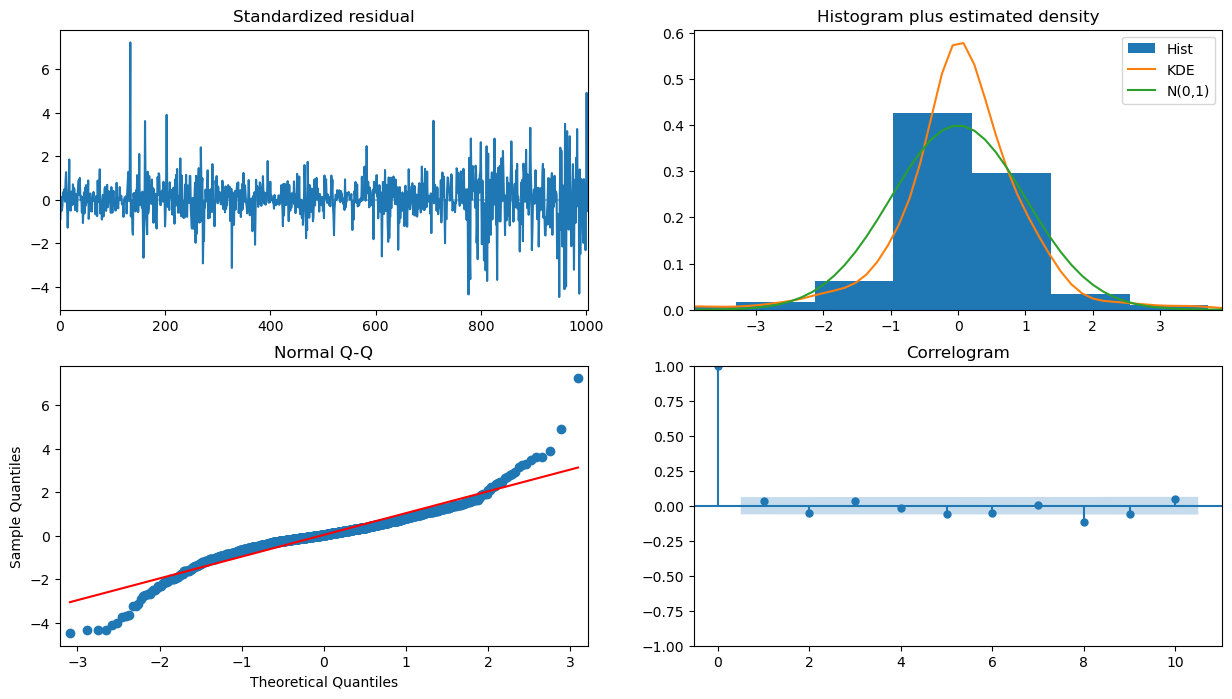

In [42]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [43]:
model_arima = ARIMA(train_data['Close'], order = (1, 1, 1))
model_fit = model_arima.fit()
model_fit.summary()


/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/statespace

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1006
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -982.541
Date:                Fri, 03 Nov 2023   AIC                           1971.082
Time:                        21:42:21   BIC                           1985.820
Sample:                             0   HQIC                          1976.682
                               - 1006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7455      0.141     -5.304      0.000      -1.021      -0.470
ma.L1          0.7931      0.130      6.102      0.000       0.538       1.048
sigma2         0.4137      0.010     43.299      0.000       0.395       0.432
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              1465.60
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

For the Next 1 Year

In [44]:
results = {'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'], 'Next 1 Year': [], 'Next 1 Month': [], 'Next 10 Days': []}

In [45]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(f'Prediction Time Frame: {pred_start_date}, {pred_end_date}')
pred = model_fit.forecast(len(test_data.index), alpha=0.05)
pred = pd.DataFrame(pred)
pred.set_index(test_data.index, inplace=True)

Prediction Time Frame: 2019-01-02 00:00:00, 2019-12-30 00:00:00


/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [46]:
# residuals = test_data['Close'] - pred['predicted_mean']
# residuals

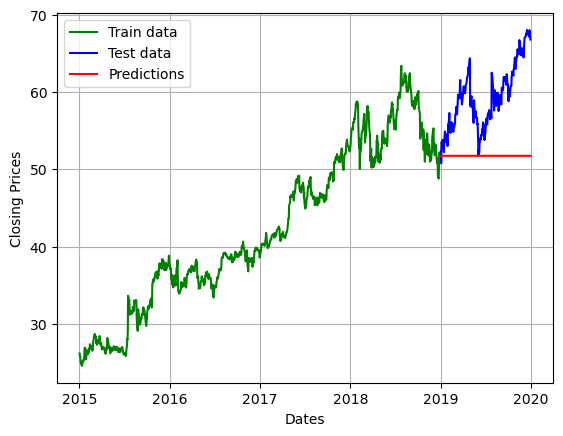

In [47]:
#Predicted Results
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data.Close, 'green', label='Train data')
plt.plot(test_data.Close, 'blue', label='Test data')
plt.plot(pred['predicted_mean'], 'red', label = 'Predictions')
plt.legend()

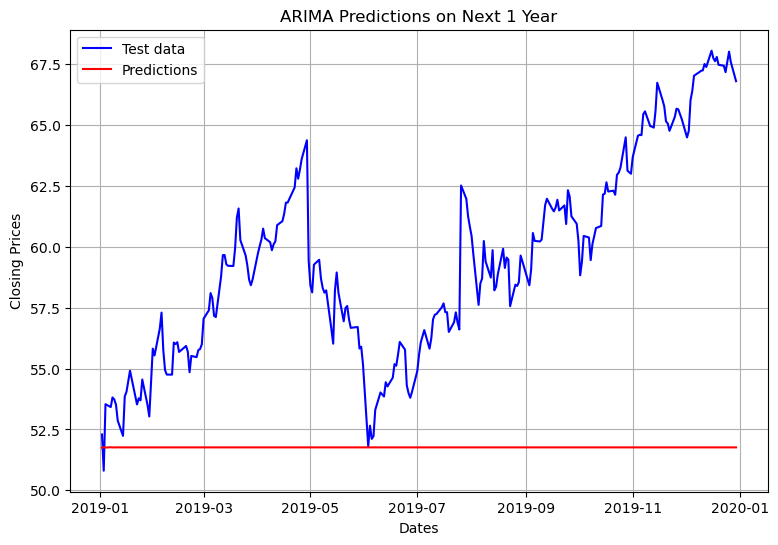

In [48]:
#Predicted Results
plt.figure(figsize = (9, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_data.Close, 'blue', label='Test data')
plt.plot(pred['predicted_mean'], 'red', label = 'Predictions')
plt.title('ARIMA Predictions on Next 1 Year')
plt.legend()

In [49]:
# report performance
mse = mean_squared_error(test_data.Close, pred['predicted_mean'])
results['Next 1 Year'].append(mse)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data.Close, pred['predicted_mean'])
results['Next 1 Year'].append(mae)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data.Close, pred['predicted_mean']))
results['Next 1 Year'].append(rmse)
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred['predicted_mean'] - test_data.Close)/np.abs(test_data.Close))
results['Next 1 Year'].append(mape)
print('MAPE: '+str(mape))

MSE: 74.67629375429156
MAE: 7.63553626670172
RMSE: 8.641544639373887
MAPE: 0.12455188563572483


For the next 30 days

In [50]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[:30]
print(f'Prediction Time Frame: {pred_start_date}, {pred_end_date}')
pred = model_fit.forecast(len(test_data[:30].index), alpha=0.05)
pred = pd.DataFrame(pred)
pred.set_index(test_data[:30].index, inplace=True)
pred.head()

Prediction Time Frame: 2019-01-02 00:00:00, DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17',
               '2019-01-18', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-28', '2019-01-29', '2019-01-30',
               '2019-01-31', '2019-02-01', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-11',
               '2019-02-12', '2019-02-13'],
              dtype='datetime64[ns]', name='Date', freq=None)


/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,predicted_mean
Date,
2019-01-02,51.748672
2019-01-03,51.772398
2019-01-04,51.754711
2019-01-07,51.767896
2019-01-08,51.758067


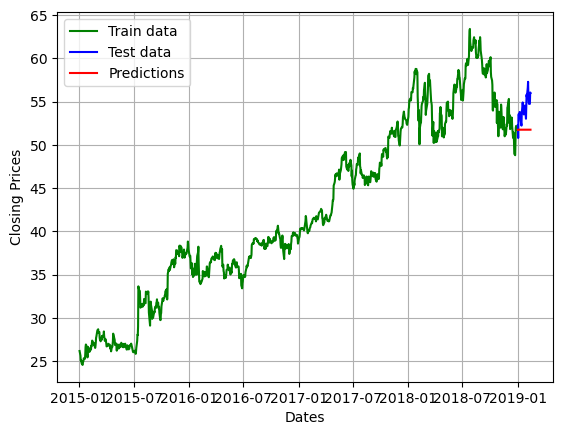

In [51]:
#Predicted Results
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data.Close, 'green', label='Train data')
plt.plot(test_data[:30].Close, 'blue', label='Test data')
plt.plot(pred['predicted_mean'], 'red', label = 'Predictions')
plt.legend()

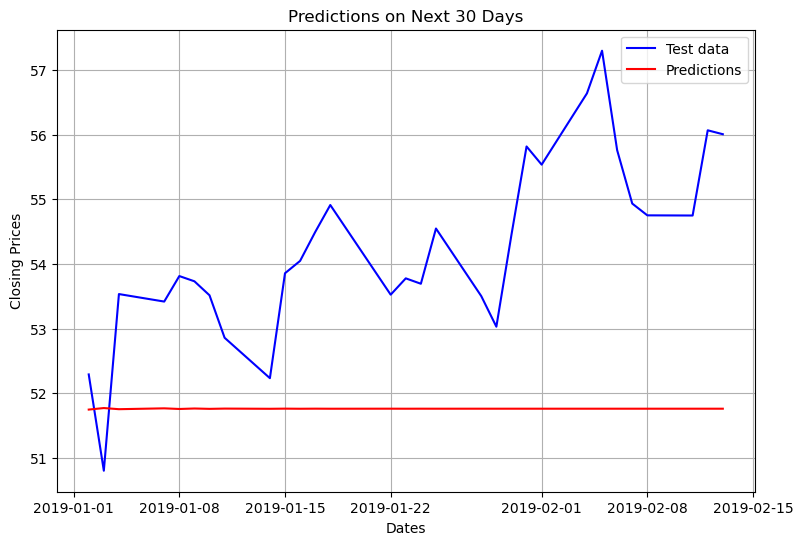

In [52]:
#Predicted Results
plt.figure(figsize = (9, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_data[:30].Close, 'blue', label='Test data')
plt.plot(pred['predicted_mean'], 'red', label = 'Predictions')
plt.title('Predictions on Next 30 Days')
plt.legend()

In [53]:
# report performance
mse = mean_squared_error(test_data[:30].Close, pred['predicted_mean'])
results['Next 1 Month'].append(mse)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data[:30].Close, pred['predicted_mean'])
results['Next 1 Month'].append(mae)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data[:30].Close, pred['predicted_mean']))
results['Next 1 Month'].append(rmse)
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred['predicted_mean'] - test_data[:30].Close)/np.abs(test_data[:30].Close))
results['Next 1 Month'].append(mape)
print('MAPE: '+str(mape))

MSE: 8.099415576711626
MAE: 2.5570041678836533
RMSE: 2.845947219593439
MAPE: 0.046597721451672576


For 10 Days

In [54]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[:10]
print(f'Prediction Time Frame: {pred_start_date}, {pred_end_date}')
pred = model_fit.forecast(len(test_data[:10].index), alpha=0.05)
pred = pd.DataFrame(pred)
pred.set_index(test_data[:10].index, inplace=True)
pred.head()

Prediction Time Frame: 2019-01-02 00:00:00, DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15'],
              dtype='datetime64[ns]', name='Date', freq=None)


/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,predicted_mean
Date,
2019-01-02,51.748672
2019-01-03,51.772398
2019-01-04,51.754711
2019-01-07,51.767896
2019-01-08,51.758067


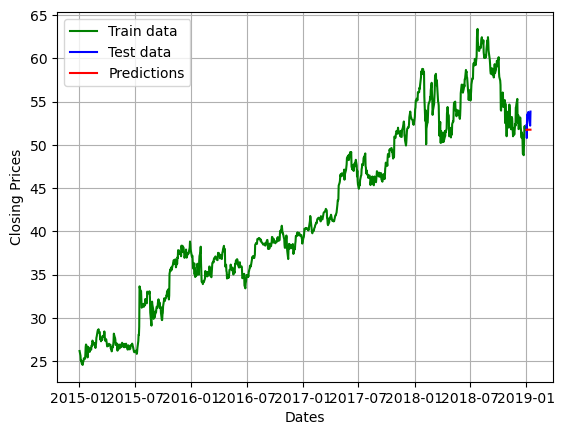

In [55]:
#Predicted Results
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data.Close, 'green', label='Train data')
plt.plot(test_data[:10].Close, 'blue', label='Test data')
plt.plot(pred['predicted_mean'], 'red', label = 'Predictions')
plt.legend()

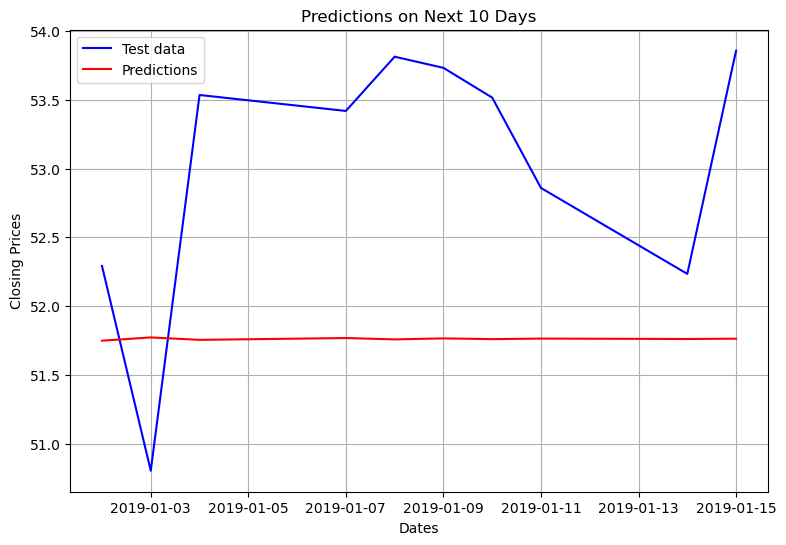

In [56]:
#Predicted Results
plt.figure(figsize = (9, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_data[:10].Close, 'blue', label='Test data')
plt.plot(pred['predicted_mean'], 'red', label = 'Predictions')
plt.title('Predictions on Next 10 Days')
plt.legend()

In [57]:
# report performance
mse = mean_squared_error(test_data[:10].Close, pred['predicted_mean'])
results['Next 10 Days'].append(mse)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data[:10].Close, pred['predicted_mean'])
results['Next 10 Days'].append(mae)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data[:10].Close, pred['predicted_mean']))
results['Next 10 Days'].append(rmse)
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred['predicted_mean'] - test_data[:10].Close)/np.abs(test_data[:10].Close))
results['Next 10 Days'].append(mape)
print('MAPE: '+str(mape))

MSE: 2.41286382890804
MAE: 1.4389017421180932
RMSE: 1.553339572955006
MAPE: 0.02699835741488186


In [58]:
df_results_arima = pd.DataFrame(results)
df_results_arima.set_index('Metric',  inplace=True)
df_results_arima = df_results_arima.apply(lambda x: round(x, 2))
df_results_arima

,Next 1 Year,Next 1 Month,Next 10 Days
Metric,,,
MSE,74.68,8.10,2.41
MAE,7.64,2.56,1.44
RMSE,8.64,2.85,1.55
MAPE,0.12,0.05,0.03


### VARMA (Vector Auto-Regressive Moving Average)

Lets check what variables will suit us for the modelling. check for stationarity

### Augmented Dickey Fuller Test

In [59]:
data = data.iloc[:, :-1]

In [60]:
def check_stationarity(data):
    for i in range(len(data.columns)):
        scores = adfuller(data[data.columns[i]], autolag='AIC')
        if scores[1] < 0.05:
            print(f'Data is stationary for column {data.columns[i]}')
        else:
            print(f'Data is not stationary for column {data.columns[i]}')

def apply_differencing(data, column):
    data[f'First_differnce_{column}'] = data[column] - data[column].shift(1)
    return data

In [61]:
check_stationarity(data)

Data is not stationary for column Open
Data is not stationary for column High
Data is not stationary for column Low
Data is not stationary for column Close
Data is not stationary for column Adj Close
Data is stationary for column Volume


In [62]:
#Apply Differenjcing
for i in data.columns:
    if i == 'Volume':
        continue
    data = apply_differencing(data, i)



In [63]:
stationary_data = data.iloc[1:, -6:]
check_stationarity(stationary_data)

Data is stationary for column Volume
Data is stationary for column First_differnce_Open
Data is stationary for column First_differnce_High
Data is stationary for column First_differnce_Low
Data is stationary for column First_differnce_Close
Data is stationary for column First_differnce_Adj Close


### Granger Causality Test

Checks if a given time-series variable effects the target 'Close'

H0: The column does'nt effect the target

H1: The column effects the target.

In [64]:
stationary_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2015-01-05 to 2019-12-30
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Volume                     1256 non-null   int64  
 1   First_differnce_Open       1256 non-null   float64
 2   First_differnce_High       1256 non-null   float64
 3   First_differnce_Low        1256 non-null   float64
 4   First_differnce_Close      1256 non-null   float64
 5   First_differnce_Adj Close  1256 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 68.7 KB


In [65]:
def grangers_test(data, columns, test = 'ssr_chi2test'):
    df = pd.DataFrame(np.zeros((len(columns), len(columns))), columns = columns, index = columns)
    for c in df.columns:
        for r in df.index:
            res = grangercausalitytests(data[[r, c]], maxlag=12, verbose=False)
            p_vals = [round(res[i+1][0][test][1], 4) for i in range(12)]
            min_p_value = np.min(p_vals)
            df.loc[r, c] = min_p_value

    df.columns = [col + '_x' for col in columns]
    df.index = [col + '_y' for col in columns]
    return df

granger_df = grangers_test(stationary_data, stationary_data.columns)
granger_df

/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: 

,Volume_x,First_differnce_Open_x,First_differnce_High_x,First_differnce_Low_x,First_differnce_Close_x,First_differnce_Adj Close_x
Volume_y,1.0000,0.1394,0.0533,0.0981,0.0532,0.0532
First_differnce_Open_y,0.0045,1.0000,0.0000,0.0000,0.0000,0.0000
First_differnce_High_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
First_differnce_Low_y,0.0080,0.0000,0.0000,1.0000,0.0000,0.0000
First_differnce_Close_y,0.0499,0.0000,0.0012,0.0000,1.0000,1.0000
First_differnce_Adj Close_y,0.0499,0.0000,0.0012,0.0000,1.0000,1.0000


In [66]:
granger_df[['First_differnce_Close_x']]

,First_differnce_Close_x
Volume_y,0.0532
First_differnce_Open_y,0.0000
First_differnce_High_y,0.0000
First_differnce_Low_y,0.0000
First_differnce_Close_y,1.0000
First_differnce_Adj Close_y,1.0000


For a variable to have an effect on the target the p-value should be less that 0.05 for a 95% confidence interval.
Hence the variables that effect the Close price are Open, High and Low.

Split into Test and Train sets

In [67]:
#Take the differenced data
final_data = data.iloc[:, :4].diff(2).dropna()

Text(0, 0.5, 'Correlation with Close Price')

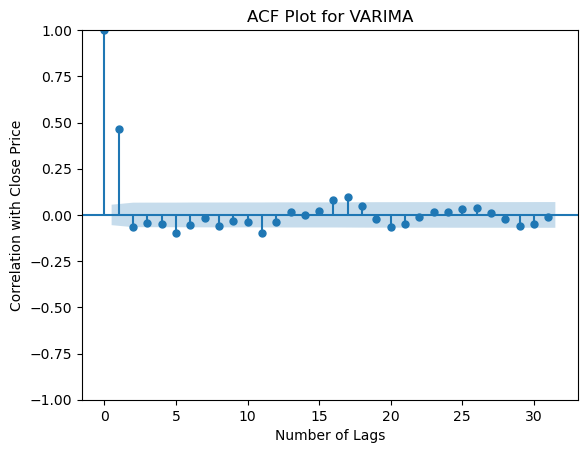

In [68]:
acf = plot_acf(final_data['Close'])
plt.title('ACF Plot for VARIMA')
plt.xlabel('Number of Lags')
plt.ylabel('Correlation with Close Price')

Text(0, 0.5, 'Correlation with Close Price')

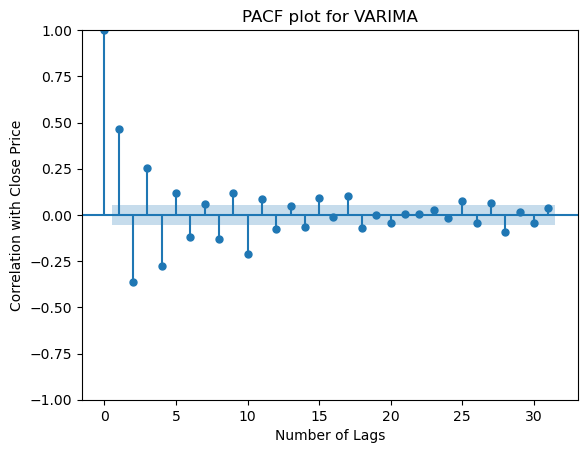

In [69]:
pacf = plot_pacf(final_data['Close'])
plt.title('PACF plot for VARIMA')
plt.xlabel('Number of Lags')
plt.ylabel('Correlation with Close Price')

In [70]:
train_data_end = dt.datetime(2018, 12, 31)
test_data_end = dt.datetime(2019, 12, 31)
train_data = final_data[:train_data_end]
test_data = final_data[train_data_end+dt.timedelta(days=1):test_data_end]

In [71]:
train_data.head()

,Open,High,Low,Close
Date,,,,
2015-01-06,-0.698582,-0.752684,-1.149343,-1.139372
2015-01-07,-0.810774,-0.851961,-0.668665,-0.636751
2015-01-08,-0.848171,-0.633013,-0.501125,0.035902
2015-01-09,-0.111692,-0.115883,-0.242334,-0.245825
2015-01-12,-0.152082,-0.374172,-0.171530,-0.505114


In [72]:
# Fit the VARIMA model
model = VARMAX(train_data, order=(1, 1))
model_fitted = model.fit(disp=False)

/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


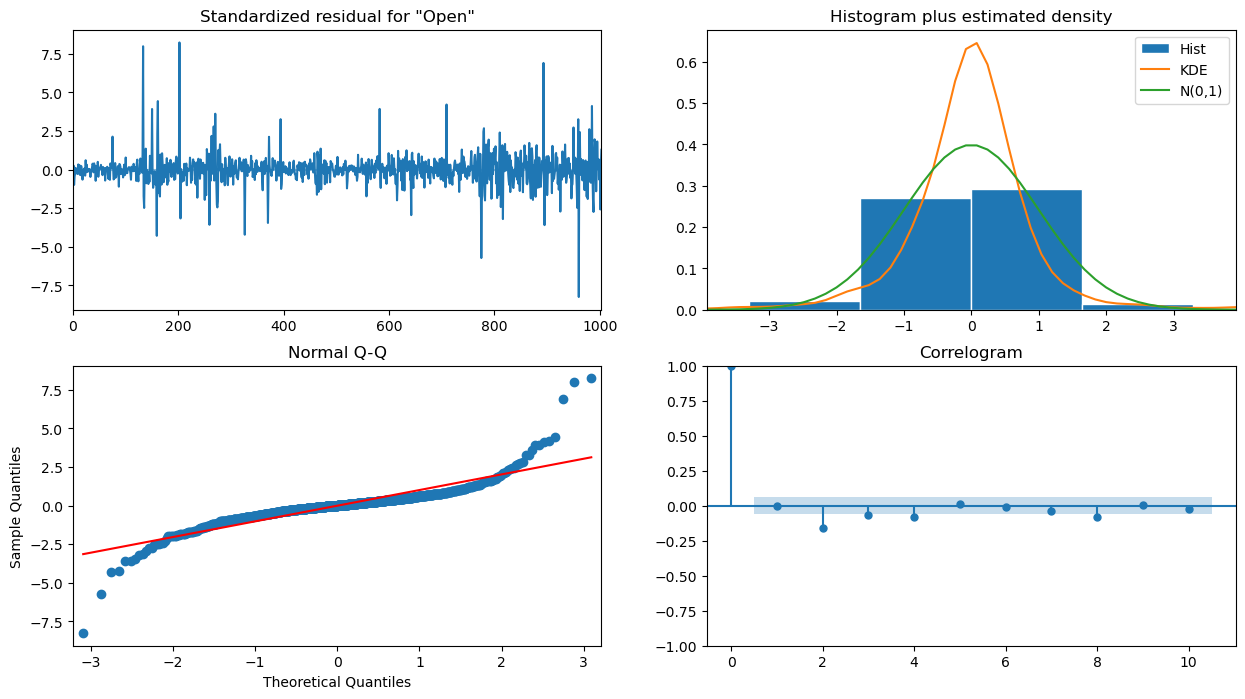

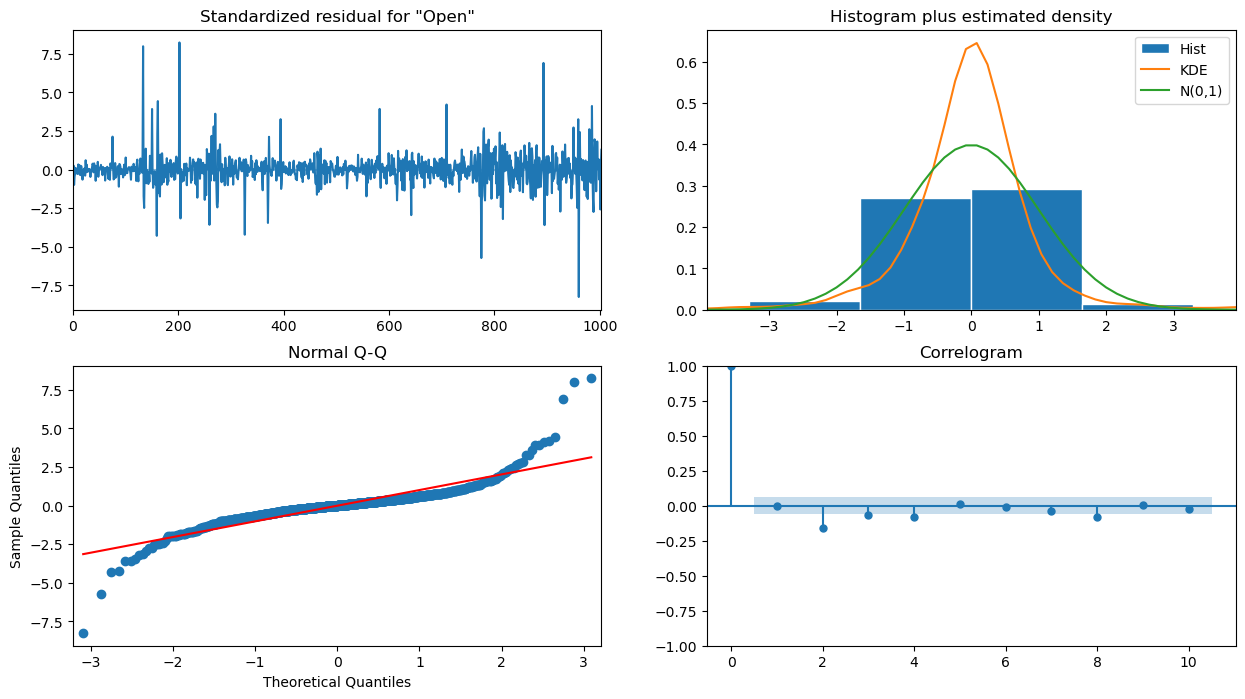

In [73]:
model_fitted.plot_diagnostics(figsize=(15, 8))

In [74]:
model_fitted.summary()

Dep. Variable:,"['Open', 'High', 'Low', 'Close']",No. Observations:,1004
Model:,"VARMA(1,1)",Log Likelihood,-1737.307
,+ intercept,AIC,3566.614
Date:,"Fri, 03 Nov 2023",BIC,3792.555
Time:,21:43:39,HQIC,3652.471
Sample:,0,,
,- 1004,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 8.92, 0.46, 18.11",Jarque-Bera (JB):,"12328.94, 535.53, 2558.14, 1328.36"
Prob(Q):,"0.97, 0.00, 0.50, 0.00",Prob(JB):,"0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"1.36, 2.86, 3.13, 2.93",Skew:,"0.66, 0.24, -0.18, -0.05"


For Next 1 Year

Prediction Time Frame: 2019-01-02 00:00:00, 2019-12-30 00:00:00


/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


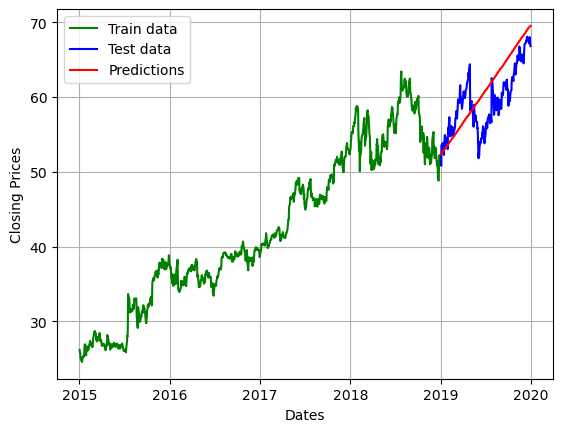

In [75]:
# Make prediction
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(f'Prediction Time Frame: {pred_start_date}, {pred_end_date}')
steps_ahead = len(test_data.index) 
forecast = model_fitted.get_forecast(steps=steps_ahead)
forecast_values = forecast.predicted_mean
forecast_values.set_index(test_data.index, inplace=True)
# Since we differenced the data, we need to undifference the predictions
forecast_values_undiff = data['Close'][pred_start_date] + np.cumsum(forecast_values)

#Predicted Results
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(data.Close[:pred_start_date], 'green', label='Train data')
plt.plot(data.Close[pred_start_date:pred_end_date], 'blue', label='Test data')
plt.plot(forecast_values_undiff['Close'], 'red', label = 'Predictions')
plt.legend()


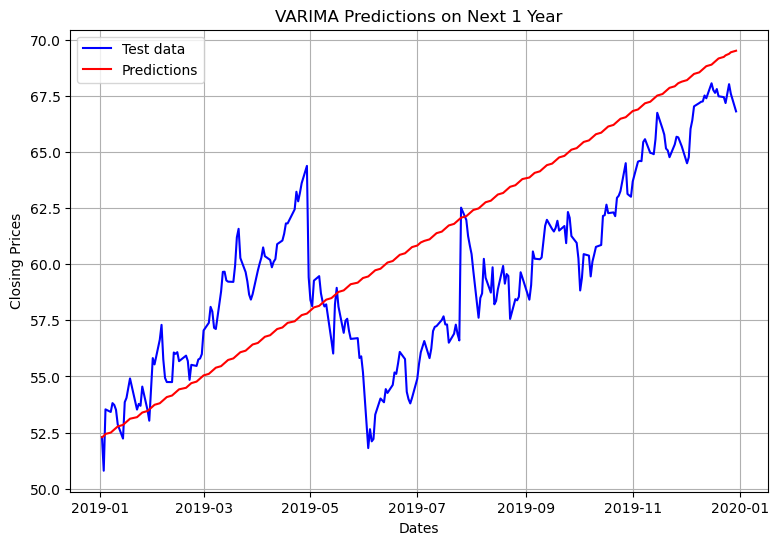

In [76]:
#Predicted Results
plt.figure(figsize = (9, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(data.Close[pred_start_date:pred_end_date], 'blue', label='Test data')
plt.plot(forecast_values_undiff['Close'], 'red', label = 'Predictions')
plt.title('VARIMA Predictions on Next 1 Year')
plt.legend()

In [77]:
results = {'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE'], 'Next 1 Year': [], 'Next 1 Month': [], 'Next 10 Days': []}

In [78]:
# report performance
mse = mean_squared_error(data.Close[pred_start_date:pred_end_date], forecast_values_undiff['Close'])
results['Next 1 Year'].append(mse)
print('MSE: '+str(mse))
mae = mean_absolute_error(data.Close[pred_start_date:pred_end_date], forecast_values_undiff['Close'])
results['Next 1 Year'].append(mae)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(data.Close[pred_start_date:pred_end_date], forecast_values_undiff['Close']))
results['Next 1 Year'].append(rmse)
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast_values_undiff['Close'] - data.Close[pred_start_date:pred_end_date])/np.abs(data.Close[pred_start_date:pred_end_date]))
results['Next 1 Year'].append(mape)
print('MAPE: '+str(mape))

MSE: 12.806422650031848
MAE: 3.1072754042582904
RMSE: 3.578606244060926
MAPE: 0.05276388920300642


For next 1 Month

Prediction Time Frame: 2019-01-02 00:00:00, 2019-02-14 00:00:00


/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


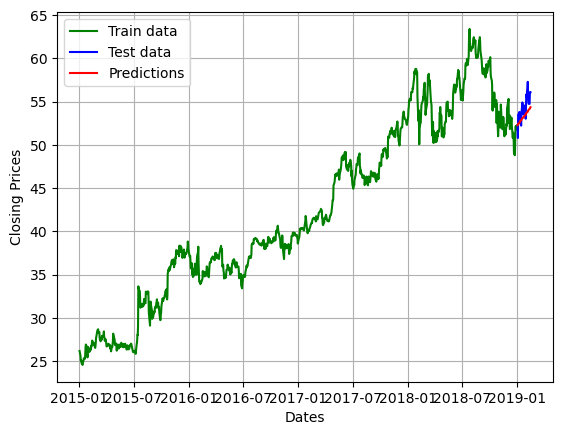

In [79]:
# Make prediction
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[30]
print(f'Prediction Time Frame: {pred_start_date}, {pred_end_date}')
steps_ahead = len(test_data[:31].index) 
forecast = model_fitted.get_forecast(steps=steps_ahead)
forecast_values = forecast.predicted_mean
forecast_values.set_index(test_data[:31].index, inplace=True)
# Since we differenced the data, we need to undifference the predictions
forecast_values_undiff = data['Close'][pred_start_date] + np.cumsum(forecast_values)

#Predicted Results
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(data.Close[:pred_start_date], 'green', label='Train data')
plt.plot(data.Close[pred_start_date:pred_end_date], 'blue', label='Test data')
plt.plot(forecast_values_undiff['Close'], 'red', label = 'Predictions')
plt.legend()

In [80]:
# report performance
mse = mean_squared_error(data.Close[pred_start_date:pred_end_date], forecast_values_undiff['Close'])
results['Next 1 Month'].append(mse)
print('MSE: '+str(mse))
mae = mean_absolute_error(data.Close[pred_start_date:pred_end_date], forecast_values_undiff['Close'])
results['Next 1 Month'].append(mae)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(data.Close[pred_start_date:pred_end_date], forecast_values_undiff['Close']))
results['Next 1 Month'].append(rmse)
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast_values_undiff['Close'] - data.Close[pred_start_date:pred_end_date])/np.abs(data.Close[pred_start_date:pred_end_date]))
results['Next 1 Month'].append(mape)
print('MAPE: '+str(mape))

MSE: 1.9438738247650196
MAE: 1.1591295893654239
RMSE: 1.3942287562538005
MAPE: 0.021094865241468648


For next 10 days

Prediction Time Frame: 2019-01-02 00:00:00, 2019-01-16 00:00:00


/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/ameybasangoudar/opt/anaconda3/envs/tensorflow-gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


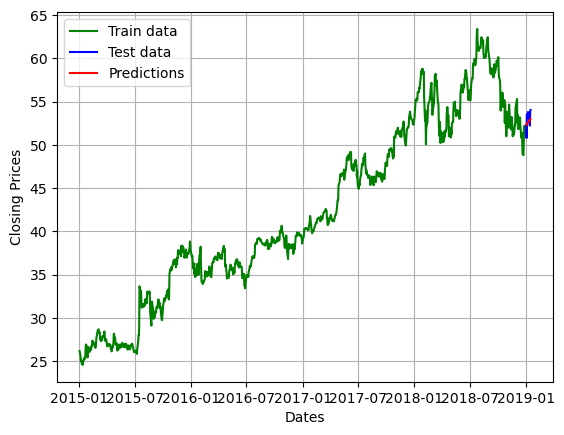

In [81]:
# Make prediction
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[10]
print(f'Prediction Time Frame: {pred_start_date}, {pred_end_date}')
steps_ahead = len(test_data[:11].index) 
forecast = model_fitted.get_forecast(steps=steps_ahead)
forecast_values = forecast.predicted_mean
forecast_values.set_index(test_data[:11].index, inplace=True)
# Since we differenced the data, we need to undifference the predictions
forecast_values_undiff = data['Close'][pred_start_date] + np.cumsum(forecast_values)

#Predicted Results
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(data.Close[:pred_start_date], 'green', label='Train data')
plt.plot(data.Close[pred_start_date:pred_end_date], 'blue', label='Test data')
plt.plot(forecast_values_undiff['Close'], 'red', label = 'Predictions')
plt.legend()

In [82]:
# report performance
mse = mean_squared_error(data.Close[pred_start_date:pred_end_date], forecast_values_undiff['Close'])
results['Next 10 Days'].append(mse)
print('MSE: '+str(mse))
mae = mean_absolute_error(data.Close[pred_start_date:pred_end_date], forecast_values_undiff['Close'])
results['Next 10 Days'].append(mae)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(data.Close[pred_start_date:pred_end_date], forecast_values_undiff['Close']))
results['Next 10 Days'].append(rmse)
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast_values_undiff['Close'] - data.Close[pred_start_date:pred_end_date])/np.abs(data.Close[pred_start_date:pred_end_date]))
results['Next 10 Days'].append(mape)
print('MAPE: '+str(mape))

MSE: 0.931215071124323
MAE: 0.8564423421384059
RMSE: 0.9649948554911176
MAPE: 0.01612577049832101


In [83]:
df_results = pd.DataFrame(results)
df_results

,Metric,Next 1 Year,Next 1 Month,Next 10 Days
0,MSE,12.806423,1.943874,0.931215
1,MAE,3.107275,1.159130,0.856442
2,RMSE,3.578606,1.394229,0.964995
3,MAPE,0.052764,0.021095,0.016126


In [84]:
df_results_arima

,Next 1 Year,Next 1 Month,Next 10 Days
Metric,,,
MSE,74.68,8.10,2.41
MAE,7.64,2.56,1.44
RMSE,8.64,2.85,1.55
MAPE,0.12,0.05,0.03


ARIMA Vs VARIMA

Source:
- https://www.youtube.com/watch?v=s3CnE2tqQdo&t=365s
- https://www.youtube.com/watch?v=N9NqTp_D_bw

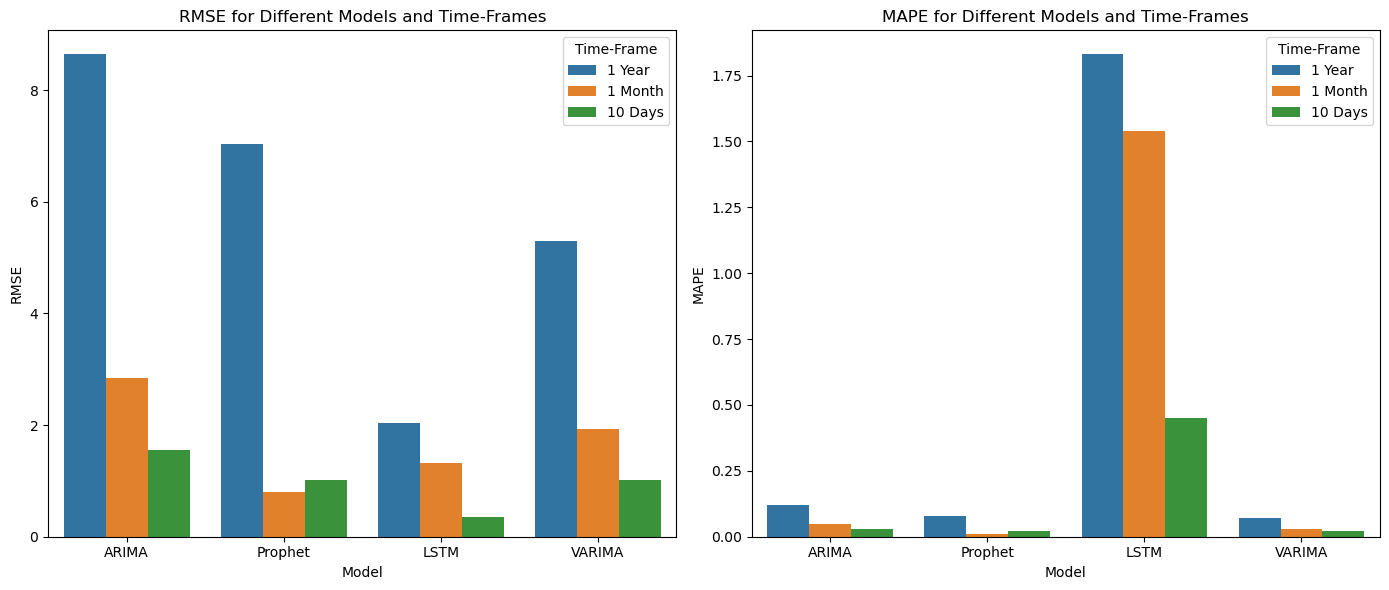

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Create a DataFrame with the data
data = {
    'Model': ['ARIMA', 'ARIMA', 'ARIMA', 'Prophet', 'Prophet', 'Prophet', 
              'LSTM', 'LSTM', 'LSTM', 'VARIMA', 'VARIMA', 'VARIMA'],
    'Time-Frame': ['1 Year', '1 Month', '10 Days', '1 Year', '1 Month', '10 Days', 
                   '1 Year', '1 Month', '10 Days', '1 Year', '1 Month', '10 Days'],
    'RMSE': [8.64, 2.85, 1.55, 7.04, 0.81, 1.01, 2.03, 1.32, 0.36, 5.30, 1.93, 1.01],
    'MAPE': [0.12, 0.05, 0.03, 0.08, 0.01, 0.02, 1.83, 1.54, 0.45, 0.07, 0.03, 0.02]
}

df = pd.DataFrame(data)

# Create a figure and a set of subplots for RMSE and MAPE
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Bar chart for RMSE
sns.barplot(ax=axes[0], x='Model', y='RMSE', hue='Time-Frame', data=df)
axes[0].set_title('RMSE for Different Models and Time-Frames')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Model')
axes[0].legend(title='Time-Frame')

# Bar chart for MAPE
sns.barplot(ax=axes[1], x='Model', y='MAPE', hue='Time-Frame', data=df)
axes[1].set_title('MAPE for Different Models and Time-Frames')
axes[1].set_ylabel('MAPE')
axes[1].set_xlabel('Model')
axes[1].legend(title='Time-Frame')

# Adjust the legend and plot layout
plt.tight_layout()
plt.show()